/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [150] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5812171963611945, tolerance: 0.22158887330528287
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34314671045945033, tolerance: 0.22158887330528287
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/

{'Positive_Emotions': ['acc_acc_z_sum', 'acc_acc_z_pct_5', 'acc_acc_z_pct_95', 'acc_acc_z_mean', 'acc_acc_z_energy', 'hrv_pnni_20', 'acc_acc_z_rms', 'hrv_lf_hf_ratio', 'hrv_n_below_mean', 'acc_acc_x_pct_95', 'acc_acc_x_rms', 'eda_tonic_ptp', 'eda_phasic_svd_entropy', 'acc_acc_x_std', 'acc_acc_z_min', 'hrv_skewness', 'acc_acc_z_kurtosis', 'acc_l2_pct_95', 'eda_tonic_iqr_5_95', 'eda_phasic_ptp'], 'Negative_Emotions': ['acc_acc_x_sum', 'acc_acc_x_pct_5', 'acc_acc_x_mean', 'acc_acc_x_pct_95', 'acc_acc_z_sum', 'acc_acc_z_pct_95', 'acc_l2_pct_95', 'acc_acc_z_pct_5', 'acc_acc_z_mean', 'acc_l2_rms', 'acc_l2_mean', 'acc_acc_y_rms', 'acc_acc_z_rms', 'acc_l2_pct_5', 'acc_acc_y_energy', 'acc_acc_z_energy', 'acc_l2_energy', 'acc_l2_sum', 'acc_acc_x_energy', 'acc_acc_y_pct_5'], 'Self_Esteem': ['acc_acc_x_rms', 'acc_acc_x_svd_entropy', 'acc_acc_x_energy', 'acc_l2_n_sign_changes', 'acc_acc_z_rms', 'eda_tonic_mean', 'acc_l2_rms', 'acc_l2_mean', 'eda_tonic_rms', 'acc_l2_pct_95', 'eda_tonic_pct_5', 'acc_

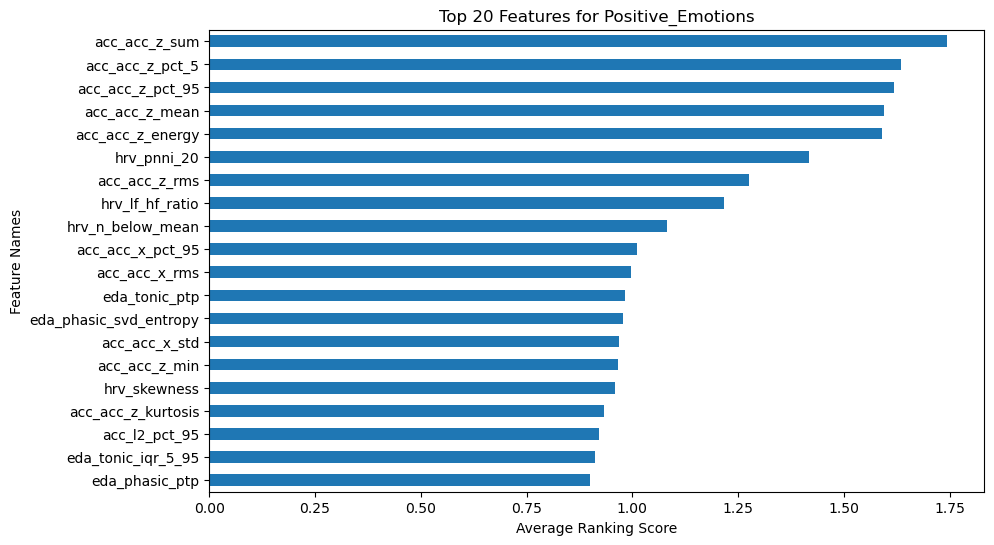

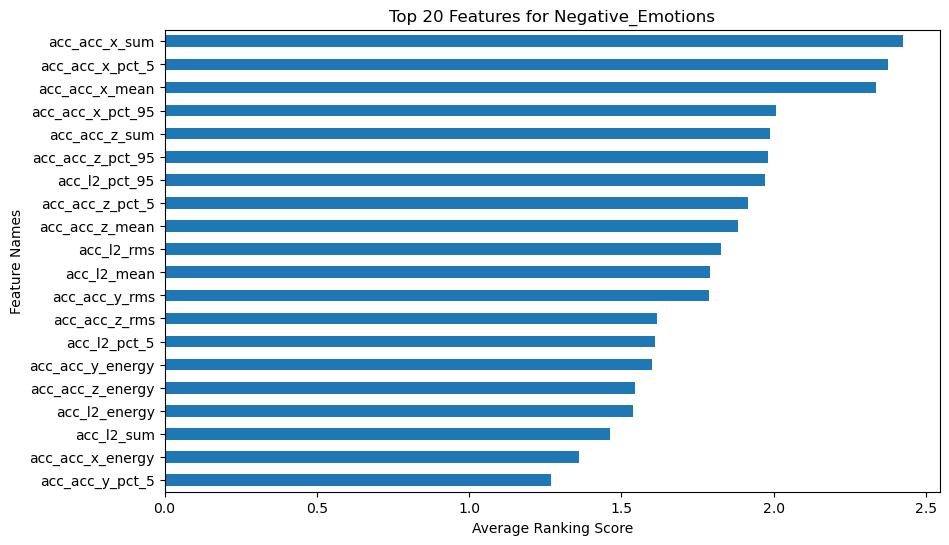

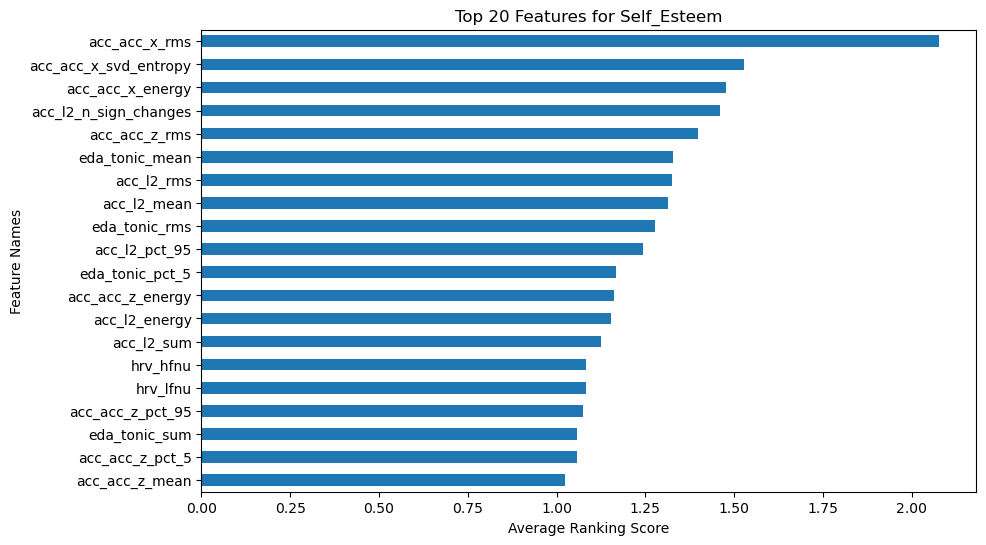

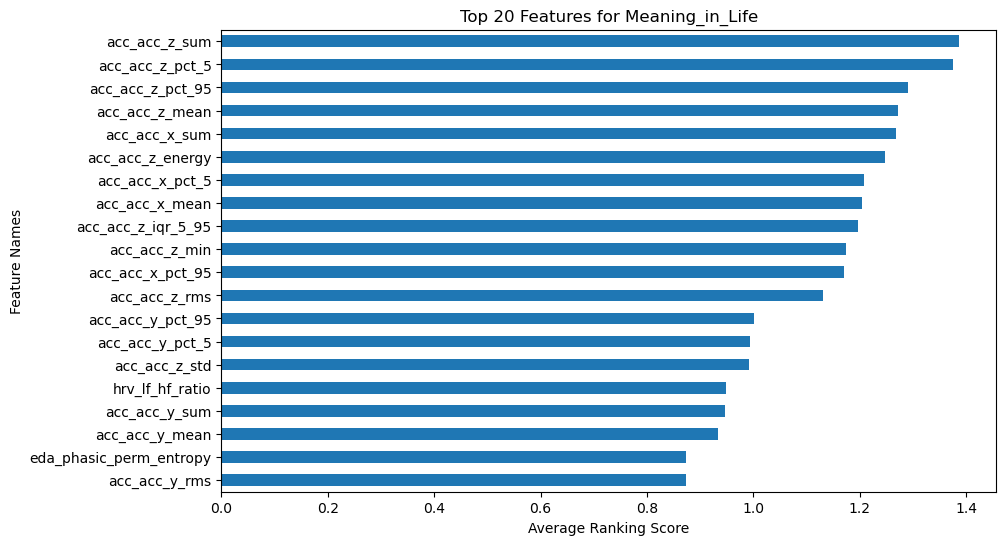

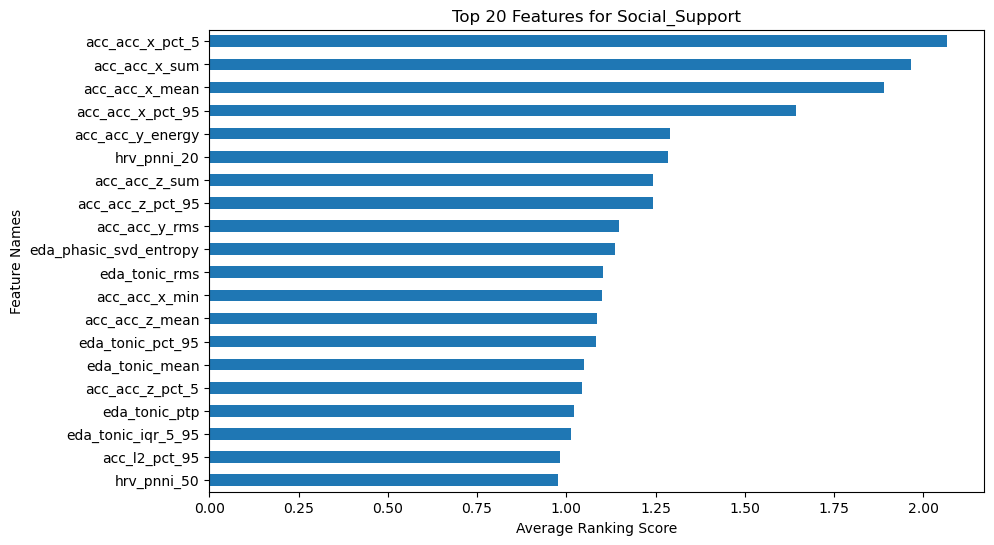

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = "processed_dataset_with_clusters.csv"
df = pd.read_csv(file_path)

# Extract features (X) and targets (y)
target_columns = ["Positive_Emotions", "Negative_Emotions", "Self_Esteem", "Meaning_in_Life", "Social_Support"]
feature_columns = df.columns.difference(target_columns)
X = df[feature_columns]
y = df[target_columns]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dataset size to speed up computation
X_train, _, y_train, _ = train_test_split(X_scaled, y, test_size=0.8, random_state=42)

# Dictionary to store rankings
feature_rankings = {target: {} for target in target_columns}

# Perform feature selection for each target variable
for target in target_columns:
    y_target = y_train[target]

    # 1. ANOVA F-score
    f_values, _ = f_classif(X_train, y_target)
    feature_rankings[target]["ANOVA"] = f_values

    # 2. Random Forest Feature Importance
    rf = RandomForestRegressor(n_estimators=30, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_target)
    feature_rankings[target]["RandomForest"] = rf.feature_importances_

    # 3. LASSO Regression
    lasso = LassoCV(cv=3, random_state=42, n_jobs=-1, max_iter=500)
    lasso.fit(X_train, y_target)
    feature_rankings[target]["LASSO"] = np.abs(lasso.coef_)

    # 4. Mutual Information
    mi = mutual_info_regression(X_train, y_target)
    feature_rankings[target]["MutualInfo"] = mi

# Convert rankings into DataFrame
ranking_df = {target: pd.DataFrame(feature_rankings[target], index=feature_columns) for target in target_columns}

# Select top 20 features for each target based on average ranking across all methods
top_features_per_target = {
    target: ranking_df[target].mean(axis=1).nlargest(20).index.tolist() for target in target_columns
}

# Display selected features for each target
print(top_features_per_target)

# Plot feature rankings
for target in target_columns:
    ranking_df[target].mean(axis=1).nlargest(20).plot(kind="barh", figsize=(10, 6))
    plt.gca().invert_yaxis()  # Invert to show highest-ranked at the top
    plt.title(f"Top 20 Features for {target}")
    plt.xlabel("Average Ranking Score")
    plt.ylabel("Feature Names")
    plt.show()
